# COVID-19 Analysis Project

According to WHO (2022), COVID-19 pandemic have resulted in over 1 million deaths in the US and over 6 million deaths worldwide. While it is observed that different variances have different mortality rates and rates of transmission, it is essential that we try to understand the trends and patterns as to when most cases and deaths related to COVID-19 are reported, so that we can understand the possible causes for the spikes and help reduce these instances. https://covid19.who.int/

1. Problem Definition

Knowing the prevalence and tends of a disease can help authorities take necessary measures to control further spread and give better recommendations and set proper guidelines to safeguard the vulnerable populations.

Given the data on confirmed COVID-19 cases, recoved patiets and deaths gathered in the US and worldwide, can we forcast the cases and deaths related to COVID-19?

2. Data

 Original data for this project came from Johns Hopkins Center for Systems Science and Engineering page in GitHub at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

 We'll be working with 4 main files:
 confirmed_US - Data with confirmed cases in the US to date.
 deaths_US -  COVID-19 related deaths in the US to date.
 confirmed_global - Confirmed cases in the world to date.
 deaths_global - COVID-19 related deaths in the world to date.

  It contains 6 parameters : id, province state, country, confirmed cases, fatalities

3. Evaluation

Reaching the lowest mean squared error (MSE) in predicting the deaths will determine the sucess of the project. 

4. Features - Exploratory Data Analysis (EDA)

Features that will be used to determine the model for this project.

    Province_State - The name of the State within the USA.
    Country_Region - The name of the Country (US).
    Last_Update - The most recent date the file was pushed.
    Lat - Latitude.
    Long_ - Longitude.
    Confirmed - Aggregated case count for the state. WHO defines the confirmed case as "a person with laboratory confirmation of 2019-nCoV infection, irrespective of clinical signs and symptoms. "
    Deaths - Aggregated death toll for the state.
    Recovered - Aggregated Recovered case count for the state.
    Active - Aggregated confirmed cases that have not been resolved (Active cases = total cases - total recovered - total deaths).
    FIPS - Federal Information Processing Standards code that uniquely identifies counties within the USA.
    Incident_Rate - cases per 100,000 persons.
    Total_Test_Results - Total number of people who have been tested.
    People_Hospitalized - Total number of people hospitalized. (Nullified on Aug 31, see Issue #3083)
    Case_Fatality_Ratio - Number recorded deaths * 100/ Number confirmed cases.
    UID - Unique Identifier for each row entry.
    ISO3 - Officialy assigned country code identifiers.
    Testing_Rate - Total test results per 100,000 persons. The "total test results" are equal to "Total test results (Positive + Negative)" from COVID Tracking Project.
    Hospitalization_Rate - US Hospitalization Rate (%): = Total number hospitalized / Number cases. The "Total number hospitalized" is the "Hospitalized – Cumulative" count from COVID Tracking Project. The "hospitalization rate" and "Total number hospitalized" is only presented for those states which provide cumulative hospital data. (Nullified on Aug 31, see Issue #3083)

5. Modeling

Since this a forcasting project, following models will be considered for the project:

Arima - fitting time series data to predict future
GARTH - Fitting data of irregular patterns
Sarima - Understand sime series with seasonality

6. Experiementation

Will be done using ARIMA and SARIMA models to understand to the best hyperparameters. 

## Getting the tools prepared

In [449]:
# Tools for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

# Models to try
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluating models
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Creating maps
import plotly.graph_objs as go 

## Helper Functions

In [450]:
def load_file(file_name):
    '''
    Returns the loaded csv files.
    '''
    return pd.read_csv(file_name)

def file_properties(file):
    '''
    Shows the shape of the file, if there are any empty values, any duplicated values and information
    about the dataframe.
    '''
    file.info()
    print(f"\n Shape is {file.shape}")
    print( f" \nEmpty values in file: {file.isna().sum()} \n")
    print(f"Duplicated values in file : {file.duplicated().sum()} \n")
#     print(file.describe())

def extra_columns(file1, file2):
    '''
    Identifying the different columns between two datasets.
    file1 = first dataset
    file2 = second dataset
    '''
    return set(file1).symmetric_difference(file2)

def clean_global_file(file):
    '''
    Removes unncessary columns, rename columns for easy data access, group the results by region, and change date format to YYYY-MM-DD
    '''
    file.drop(['Province/State', 'Lat', 'Long'], axis = 1, inplace = True)
    file.rename(columns = {'Country/Region': 'Regions'}, inplace = True)
    file = file.groupby('Regions').sum()
    file = file.transpose()
    file.index = pd.to_datetime(file.index)
    return file

def format_date(file):
    '''
    formats date to the yyyy-mm-dd format with the index of the table to have the name, 'Date'.
    file = file being formated
    '''
    file = file.transpose()
    file.index.name = 'Dates'
    file.index = pd.to_datetime(file.index)
    return file
    
def new_cases_global(file):
    '''
    Visualize new cases globally.
    '''
    fig, ax = plt.subplots(figsize = (20,7))
    ax.plot(file)
    ax.set(title= 'New Cases Globally',
          xlabel = "Countries",
          ylabel = 'New Cases')
    plt.xticks(rotation = 90);

def most_cases(file, year):
    '''
    Visualize data from the most cases to the least cases on a given year.
    file = File in question, year_global, year_deaths_global etc.
    year = 2020-12-31, etc. in string format
    '''
    file = file.sort_values(by = year, axis = 1, ascending = False)
    file.T.head(10).plot(kind = 'bar', figsize = (20,7))
    plt.xticks(rotation = 90)

def death_rate(file):
    '''
    Visualize the death rate according to the years
    file = file in question
    '''
    file.index= [1,2,3,4,5,6]
    # Create new colums
    file.loc['Death_Rate_2020%'] = file.loc[4]/file.loc[1]*100
    file.loc['Death_Rate_2021%'] = file.loc[5]/file.loc[2]*100
    file.loc['Death_Rate_2022%'] = file.loc[6]/file.loc[3]*100
    new_file = file.drop([1, 2,3,4,5,6], axis = 0)
    new_file.T.plot(figsize = (20,6))
    plt.xticks(rotation =90)
    plt.title('Death Rate According to Year'); 
    
def prevalence_map (dataset, time):
    '''
    Visualize the prevelance of cases in a specific time frame.
    dataset = dataset interested
    'time' = time frame in question, by date, month, or year as a string
    '''
    # Compiling data into a dictionary
    data = dict(
        type = 'choropleth',
        colorscale = 'jet',
        locations =dataset.columns,
        locationmode = "country names",
        z = dataset.T[time],
        text = dataset.columns,
        colorbar = {'title' : 'Number of Cases'},
      )

    # Creating a side bar
    layout = dict(title = 'Cases Related to COVID-19',
                  geo = dict(projection = {'type':'mercator'})
                 )

    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap,validate=False)
    

def find_order(train_dataset, test_dataset, region, dataset):
    '''
    Find the best p,q,d combination with the least RMSE values
    training_dataset = training dataset in the file which is about 70% of the full file.
    test_dataset = test dataset which is about 30% of the full file
    state/country = If its a file about US, this would be the state in question.
    full_file_length = the total rows of records in the complete file
    '''
    p = [0,1,2,3,4,5,6,7,8]
    d = [0,1,2]
    q = [0,1,2,3,4,5,6,7,8]

    pdq_combinations = list(itertools.product(p, d, q))

    pdqs = []
    rmse = []

    # Since we're looking for one state at a time, we choose CA, since it had the highest number of confirmed cases and deaths.
    for pdq in pdq_combinations:
        try:
            model = ARIMA(train_dataset[region], order = pdq).fit()
            pred = model.predict(start = len(train_dataset), end = (len(dataset)-1))
            error = np.sqrt(mean_squared_error(test_dataset[region], pred))
            pdqs.append(pdq)
            rmse.append(error)  
            results = pd.DataFrame(index = order, data = rmse, columns = ['RMSE'])
            results.to_csv("Arima.csv")
    
        except:
            continue
        
    results = pd.DataFrame(index = pdqs, data = rmse, columns = ['RMSE'])
    results.to_csv('Arima.csv')  
    print(results['RMSE'].idxmin(), results['RMSE'].min())
    

def plot_preds(training_dataset, test_dataset,region, preds, string_file_name):
    '''
    plots the training, test and predicted data
    file_name = The file which has been split into training and test datasets.
    string_file_name = file name in parenthese
    '''
    training_dataset[region].plot(color = 'blue', label = 'Training Data', legend = True, figsize = (10,6))
    test_dataset[region].plot(color = 'pink', label = 'Test Data', legend = True)
    preds.plot(color = 'purple', label = 'Predictions', legend = True )
    plt.title(f'Predictions in {string_file_name.capitalize()}: {region}');
    

def sarimax(ts,all_param):
    '''
    ts = training dataset
    all_params  = parameter list tried on
    '''
  
    results = []
    
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
            
        except Exception as e:
            print(e)
            continue
    results.sort(key=lambda x: x[1])
    
    return results[:3]


def plot_sarimax_preds(training_data, region, test_data, order_set, s_order_set, dataset):
    '''
    region = country / state
    s_order = seasonal order
    dataset = original dataset before it was split into training and test data sets
    '''
    model = SARIMAX(training_data[region], order = order_set, seasonal_order = s_order_set).fit()
    preds = model.predict(start = len(training_data), end = (len(dataset)+3))
    plt.figure(figsize= (15,8))
    plt.plot(preds, color = 'blue', label = 'Model Predictions')
    plt.plot(test_data[region], color = 'orange', label = "Actual Data")
    plt.legend();


### Loading Files

In [451]:
# Confirmed Cases of COVID-19 in the US according to states
confirmed_US = load_file("covid-project/time_series_covid19_confirmed_US.csv")
# Deaths associated with COVID-19 in the US
deaths_US = load_file("covid-project/time_series_covid19_deaths_US.csv")
# Confirmed cases of COVID-19 in the world according to the country 
confirmed_global = load_file("covid-project/time_series_covid19_confirmed_global.csv")
# Deaths associated with COVID-19 in the world
deaths_global = load_file("covid-project/time_series_covid19_deaths_global.csv")

### Exploratory Data Analysis (EDA)

#### US

In [4]:
confirmed_US.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22,3/29/22,3/30/22,3/31/22,4/1/22,4/2/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15607,15611,15611,15611,15616,15619,15621,15655,15655,15659
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,55365,55373,55373,55373,55385,55392,55408,55414,55414,55420
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5478,5478,5478,5478,5655,5656,5656,5656,5656,5656
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6415,6415,6415,6415,6416,6417,6418,6418,6418,6417
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,14894,14896,14896,14896,14898,14899,14899,14900,14900,14901


In [5]:
# Reviewing the properties of Confirmed_US dataset
file_properties(confirmed_US)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Columns: 813 entries, UID to 4/2/22
dtypes: float64(3), int64(804), object(6)
memory usage: 20.7+ MB

 Shape is (3342, 813)
 
Empty values in file: UID         0
iso2        0
iso3        0
code3       0
FIPS       10
           ..
3/29/22     0
3/30/22     0
3/31/22     0
4/1/22      0
4/2/22      0
Length: 813, dtype: int64 

Duplicated values in file : 0 



In [6]:
deaths_US.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/24/22,3/25/22,3/26/22,3/27/22,3/28/22,3/29/22,3/30/22,3/31/22,4/1/22,4/2/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,209,209,209,209,210,211,211,211,211,211
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,673,674,674,674,675,675,675,675,675,675
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,97,97,97,97,97,97,97,97,97,97
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,101,101,101,101,101,101,101,101,101,101
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,230,233,233,233,235,236,236,236,236,237


In [7]:
file_properties(deaths_US)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Columns: 814 entries, UID to 4/2/22
dtypes: float64(3), int64(805), object(6)
memory usage: 20.8+ MB

 Shape is (3342, 814)
 
Empty values in file: UID         0
iso2        0
iso3        0
code3       0
FIPS       10
           ..
3/29/22     0
3/30/22     0
3/31/22     0
4/1/22      0
4/2/22      0
Length: 814, dtype: int64 

Duplicated values in file : 0 



confirmed_US file has 775 columns where as deaths_US dataset has 776 columns. Since the data contained in these two sets are similar, its worth understanding the extra column in deaths_US file and its significance.

In [8]:
# identifying the extra column in deaths_US
extra_columns(deaths_US,confirmed_US)

{'Population'}

deaths_US has all the columns as confirmed_US, plus one extra column: Population

Both confirmed_US and deaths_US datasets have 6 columns that are object data type whereas the rest are either floats or integers

It'll be beneficial to understand which columns hold object datatype values for when it comes to data analysis.

#### Manipulating the US datasets to show just the States and number of cases by dates

In [9]:
# Dropping all the columns except for the state and dates columns
confirmed_US.drop([ 'UID','iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis = 1, inplace = True)

deaths_US.drop(['UID','iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'], axis = 1, inplace = True)
                   
# Change Province_State column name to state for easier interpretretting
confirmed_US.rename(columns = {'Province_State': 'States'}, inplace = True)
deaths_US.rename(columns = {'Province_State': 'States'}, inplace = True)

#Get sum of cases according to state
confirmed_US = confirmed_US.groupby('States').sum()
confirmed_US.head()

deaths_US = deaths_US.groupby('States').sum()

# Changing the date format to YY-MM-DD
confirmed_US = format_date(confirmed_US)
deaths_US = format_date(deaths_US)





#### View Confirmed Cases by Month

In [10]:
confirmed_US.head()

States,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Dates,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-26,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Total Monthly Cases 

In [11]:
total_monthly_US = confirmed_US.resample('M').sum()
total_monthly_US.head()

States,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Dates,,,,,,,,,,,,,,,,,,,,,
2020-01-31,0,0,0,6,0,13,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
2020-02-29,0,0,0,29,0,244,0,0,0,0,...,0,0,0,0,0,0,35,0,0,0
2020-03-31,6735,808,0,6783,3721,53289,18579,14573,1844,729,...,13685,21333,5370,1839,205,6847,45411,760,9404,716
2020-04-30,127476,8403,0,128753,52677,854561,264414,466219,67466,1470,...,195332,369373,81945,21165,1485,223912,325296,21077,118808,9826
2020-05-31,377501,12588,0,417640,150164,2492673,662304,1124193,229083,1519,...,543238,1209742,221285,29030,2116,926151,561785,47180,383868,22805


#### Let's view new cases per day, instead of cases up to data:

In [12]:
daily_US = confirmed_US.diff(axis = 0)
daily_US.tail()

States,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Dates,,,,,,,,,,,,,,,,,,,,,
2022-03-29,284.0,0.0,164.0,0.0,144.0,1740.0,1342.0,365.0,48.0,0.0,...,430.0,5425.0,98.0,89.0,9.0,867.0,0.0,94.0,451.0,56.0
2022-03-30,253.0,826.0,0.0,0.0,97.0,1802.0,1454.0,458.0,86.0,0.0,...,297.0,2453.0,133.0,219.0,4.0,798.0,1521.0,128.0,574.0,0.0
2022-03-31,258.0,0.0,41.0,10143.0,107.0,2141.0,1527.0,0.0,108.0,0.0,...,238.0,3700.0,140.0,174.0,0.0,804.0,0.0,88.0,529.0,0.0
2022-04-01,26.0,528.0,334.0,0.0,107.0,8133.0,1455.0,1243.0,99.0,0.0,...,305.0,2644.0,0.0,161.0,20.0,859.0,1492.0,95.0,508.0,55.0
2022-04-02,115.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,102.0,0.0,...,188.0,2879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Visualizing New Cases on a Monthly Basis

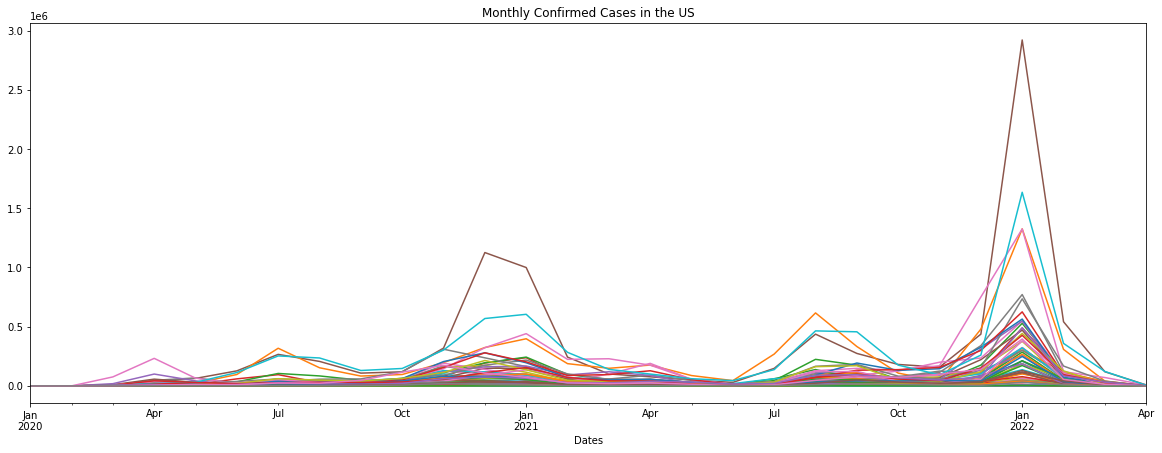

In [13]:
monthly_US = daily_US.resample('M').sum()
monthly_US.plot( figsize = (20,7), legend = None)
plt.title('Monthly Confirmed Cases in the US');

Pattern of increased cases around the end of the year and the beginning of the following year is prominent.

Could it be the holidays gatherings that created the spike, or the fact that more people got tested prior to visiting the loved ones that got resulted in higher number of new cases, or all the reasons above?

#### Visualizing New Cases on A yearly Basis

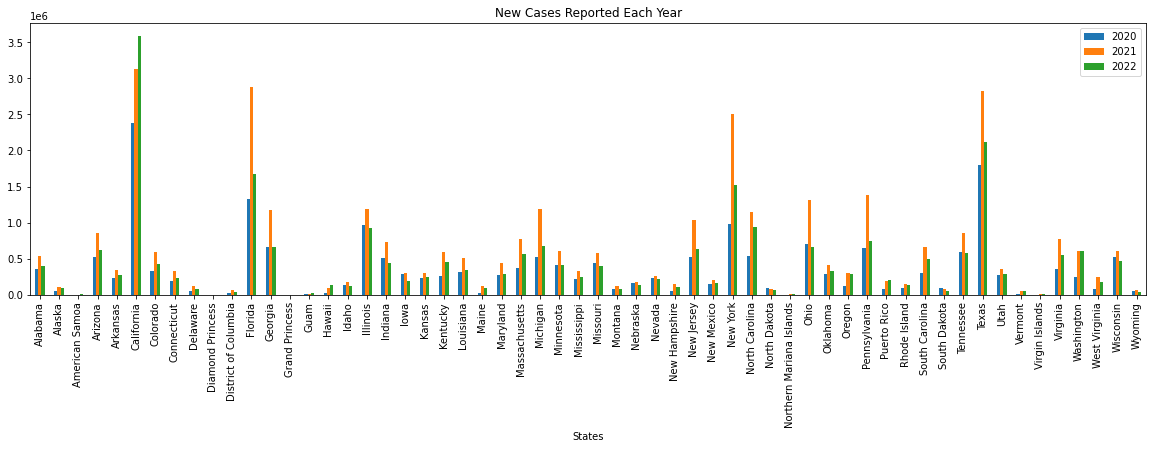

In [14]:
yearly_US = daily_US.resample('Y').sum()
yearly_US.T.plot(kind = 'bar', figsize = (20,5))
plt.title('New Cases Reported Each Year')
plt.legend(['2020', '2021', '2022']);

Confirmed cases US in 2021 >2020     
    
    1. Not a true representation ? 
    2. No tests were available at the beginning of the pandemic? 
    3. 2021 had a different variant with higher transmissibility?
    4. All? 


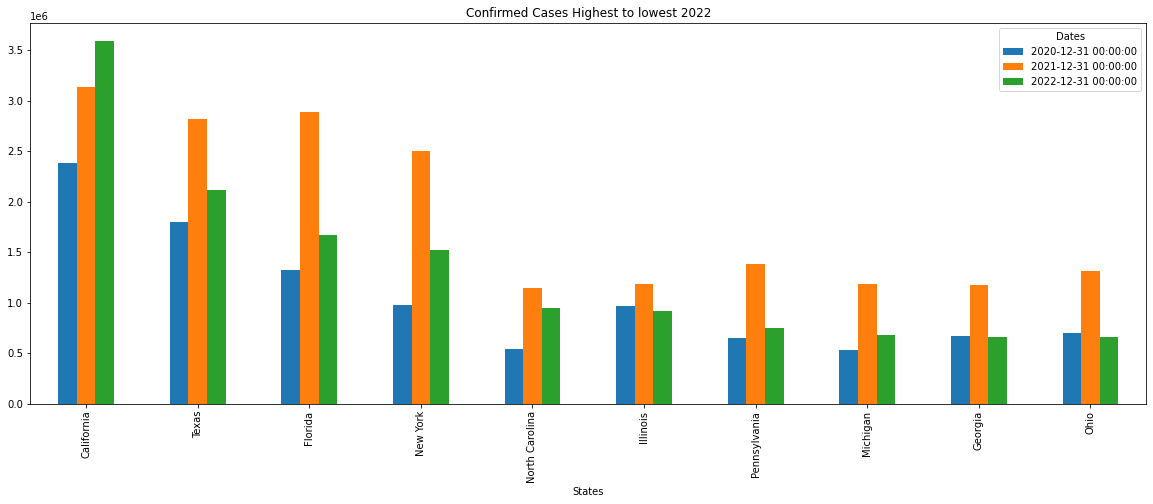

In [15]:
most_cases(yearly_US, '2022-12-31')
plt.title('Confirmed Cases Highest to lowest 2022');

Compared to 2020, 2021 have by far had the highest confirmed cases in every state in the United States. For example, CA have had more confirmed cases of COVID-19 in 2021, compared to 2020. And in particularly, the number of new cases for 2022 has exceeded the total incidents in 2021 in CA. This would be a good place to ask if the policies put in place really work. 

Additionally, this would be a place to pause and ask if this was a true indication of the prevelence of the disease, or have other factors such as lack of testing kits at the earlier months of 2020 contribute to being able to diagnose patients with COVID-19.

The confirmed cases highest at CA, following, TX, FL, NY. 

### Deaths in the US

#### Visualize the daily deaths in the 4 main states, CA, TX, FL, NY

In [16]:
daily_deaths_US = deaths_US.diff(axis = 0)


#### Visualizing deaths on a monthly basis

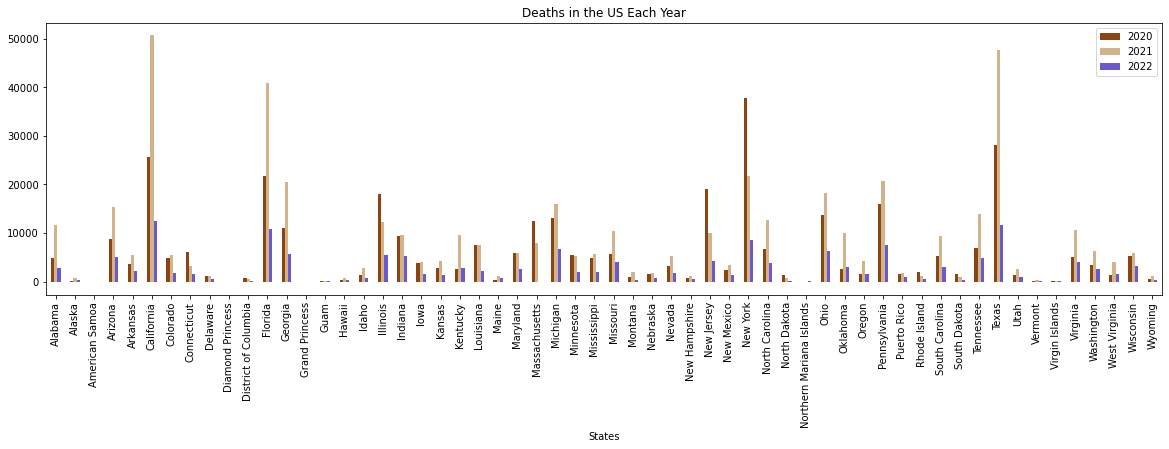

In [17]:
yearly_deaths_US = daily_deaths_US.resample("Y").sum()
yearly_deaths_US.T.plot(kind = 'bar', figsize = (20,5), color = ['saddlebrown', 'tan', 'slateblue'])
plt.legend(['2020', '2021', '2022'])
plt.title('Deaths in the US Each Year');

At the beginning of pandamic, NY had the biggest spike around April, 2020, when the other states had mild increases in death tolls. And surprisingly that was the only time the high deaths were recorded in NY compared to the other states. Further research is needed to understand if there were specific policies that were implemented to reduce the death rate significantly, or if there was any errors in record keeping. 

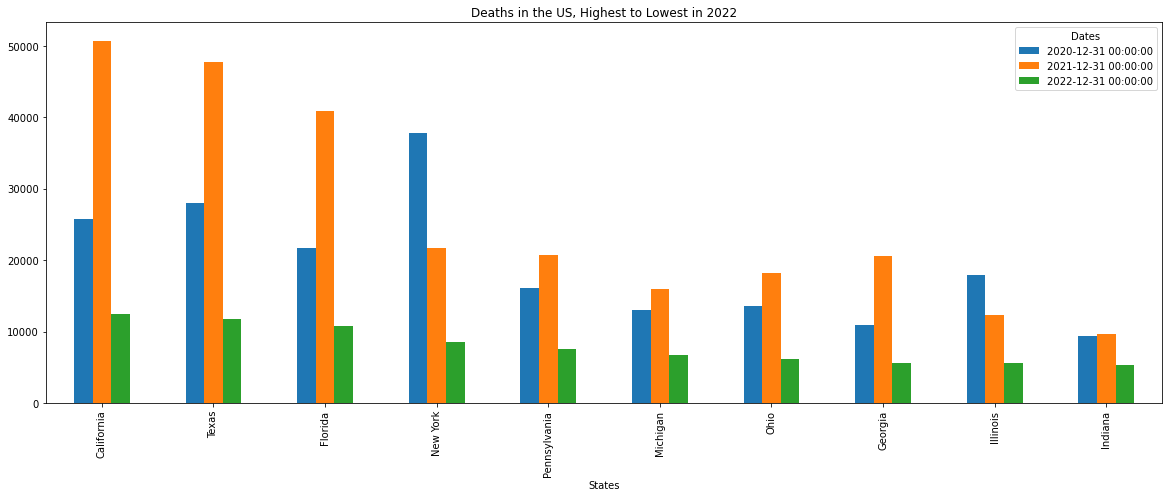

In [18]:
most_cases(yearly_deaths_US, '2022-12-31')
plt.title('Deaths in the US, Highest to Lowest in 2022');

NY had the highest number of deaths at the beginning of the pandamic. How did they manage to get the death rates so low? 

Also, 2021 had the highest number of deaths compared to 2020 and 2022 throughout the country. 
However, even though CA had the highest number of deaths, followed by TX, NY had more deaths than FL, even though FL had more confirmed cases. How is this possible? Is this lack of testing related misinformation or a drawback in managing care?

### Creating a Geographical Presentation

In [78]:
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

In [297]:
prevalence_map(yearly_global, '2022-12-31')

### Understanding The Death Rate in The US

#### Getting New Confirmed Cases and Deaths into One Place

In [20]:
totals_US= pd.concat([yearly_US, yearly_deaths_US], axis = 0)
totals_US


States,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Dates,,,,,,,,,,,,,,,,,,,,,
2020-12-31,361226.0,47014.0,0.0,520207.0,225138.0,2385401.0,334097.0,185708.0,57456.0,49.0,...,585656.0,1803482.0,276612.0,7412.0,2036.0,349584.0,246751.0,85334.0,520438.0,44409.0
2021-12-31,535388.0,110155.0,11.0,861281.0,341348.0,3134088.0,595178.0,324480.0,122910.0,0.0,...,851831.0,2819888.0,360380.0,57035.0,7612.0,768934.0,602323.0,242828.0,600225.0,71229.0
2022-12-31,398854.0,90570.0,3806.0,625692.0,266604.0,3590265.0,418806.0,227088.0,79482.0,0.0,...,583506.0,2121072.0,290930.0,52353.0,6008.0,551232.0,607189.0,169702.0,465105.0,40529.0
2020-12-31,4827.0,206.0,0.0,8864.0,3676.0,25764.0,4814.0,5995.0,1061.0,0.0,...,6907.0,28066.0,1269.0,136.0,23.0,5032.0,3461.0,1338.0,5242.0,438.0
2021-12-31,11628.0,772.0,0.0,15365.0,5472.0,50751.0,5457.0,3165.0,1225.0,0.0,...,13880.0,47678.0,2518.0,335.0,66.0,10555.0,6392.0,3998.0,5931.0,1088.0
2022-12-31,2858.0,250.0,4.0,5039.0,2103.0,12497.0,1706.0,1619.0,584.0,0.0,...,4836.0,11715.0,927.0,146.0,22.0,4127.0,2657.0,1499.0,3144.0,265.0


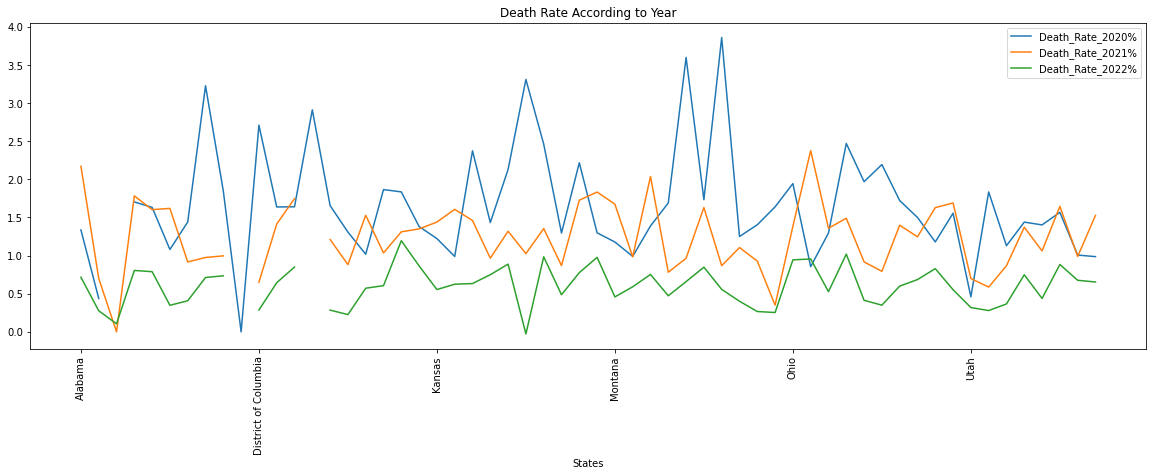

In [21]:
# Visualize death rate in the US in the last 3 years. 
death_rate(totals_US)

Looking at the graph, it is clear that, the death rates in almost every state have come down significantly, compared to the beginning of the pandamic in 2020 to now. Since the death rate reduction could be due to the disease variant, therapeutics and COVID-management guidelines, its important to do further research to understand if any specific factor or all contributed to this decline of death rates in the general population.

## Analyzing Global Data

### Manipulating the Global datasets

In [22]:
# Remove unncessary columns and rename columns for easy data access from Confirmed Cases File
confirmed_global = clean_global_file(confirmed_global)

# Remove unncessary columns and rename columns for easy data access from Deaths File
deaths_global = clean_global_file(deaths_global)


In [23]:
confirmed_global.tail()

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2022-03-29,177658,273529,265651,39713,99138,11,7491,9032162,422484,4447442,...,885980,237687,2712,520169,9386489,655750,535,11803,316550,246042
2022-03-30,177716,273608,265662,40024,99138,11,7491,9035127,422498,4507681,...,887028,237710,3128,520373,9472254,655750,535,11805,316550,246182
2022-03-31,177747,273677,265671,40024,99169,11,7491,9037911,422519,4573066,...,887935,237749,3379,520373,9564609,655750,535,11806,316850,246286
2022-04-01,177782,273759,265679,40024,99194,11,7493,9039838,422540,4628163,...,888639,237787,3710,520497,9650663,655750,535,11806,316941,246414
2022-04-02,177803,273823,265684,40024,99194,11,7493,9040640,422563,4676260,...,889132,237828,3881,520708,9716282,655750,535,11806,317031,246481


In [24]:
deaths_global.tail()

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2022-03-29,7665,3492,6874,153,1900,0,135,127970,8611,5959,...,7156,1637,1,5680,42413,5655,0,2143,3966,5439
2022-03-30,7667,3492,6874,153,1900,0,135,127997,8611,5993,...,7156,1637,2,5682,42454,5655,0,2143,3966,5440
2022-03-31,7670,3492,6874,153,1900,0,135,128019,8613,6008,...,7159,1637,2,5682,42493,5655,0,2143,3966,5444
2022-04-01,7670,3492,6874,153,1900,0,135,128052,8616,6365,...,7161,1637,2,5683,42526,5655,0,2143,3966,5444
2022-04-02,7671,3492,6874,153,1900,0,135,128059,8616,6383,...,7162,1637,2,5685,42563,5655,0,2143,3967,5446


#### Identifying Any Unique Columns Between confirmed_global and deaths_global

In [25]:
extra_columns(confirmed_global, deaths_global)

set()

Both global sets of confirmed cases and deaths have the same number of columns which  makes the analysis easier.

#### Identifying New Cases per Day

In [26]:
daily_global = confirmed_global.diff(axis = 0)
daily_global.tail()

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2022-03-29,56.0,97.0,10.0,0.0,23.0,0.0,0.0,3432.0,16.0,65523.0,...,1238.0,8.0,79.0,0.0,111640.0,0.0,0.0,0.0,0.0,115.0
2022-03-30,58.0,79.0,11.0,311.0,0.0,0.0,0.0,2965.0,14.0,60239.0,...,1048.0,23.0,416.0,204.0,85765.0,0.0,0.0,2.0,0.0,140.0
2022-03-31,31.0,69.0,9.0,0.0,31.0,0.0,0.0,2784.0,21.0,65385.0,...,907.0,39.0,251.0,0.0,92355.0,0.0,0.0,1.0,300.0,104.0
2022-04-01,35.0,82.0,8.0,0.0,25.0,0.0,2.0,1927.0,21.0,55097.0,...,704.0,38.0,331.0,124.0,86054.0,0.0,0.0,0.0,91.0,128.0
2022-04-02,21.0,64.0,5.0,0.0,0.0,0.0,0.0,802.0,23.0,48097.0,...,493.0,41.0,171.0,211.0,65619.0,0.0,0.0,0.0,90.0,67.0


#### Visualize New Confirmed Cases on a Monthly Basis

In [27]:
monthly_global = daily_global.resample('M').sum()

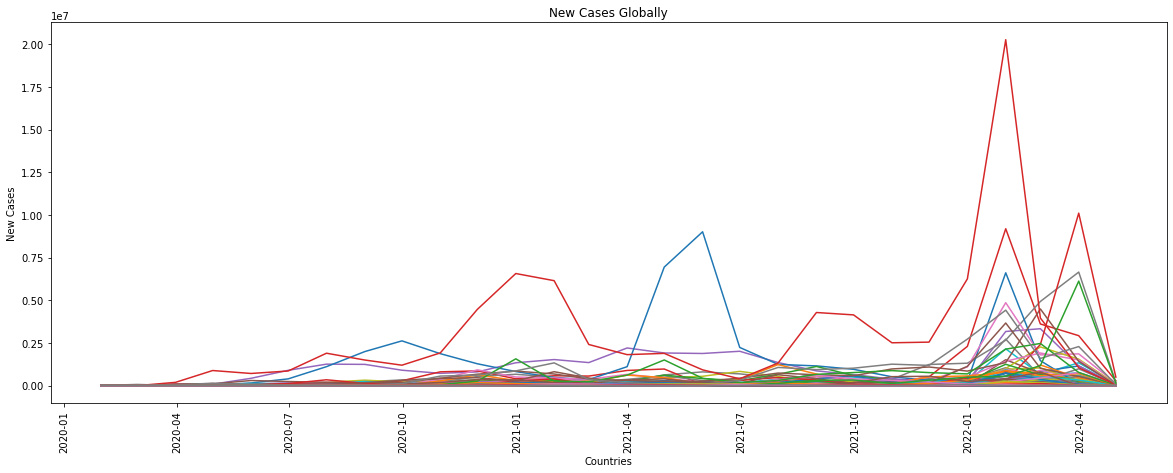

In [28]:
new_cases_global(monthly_global)

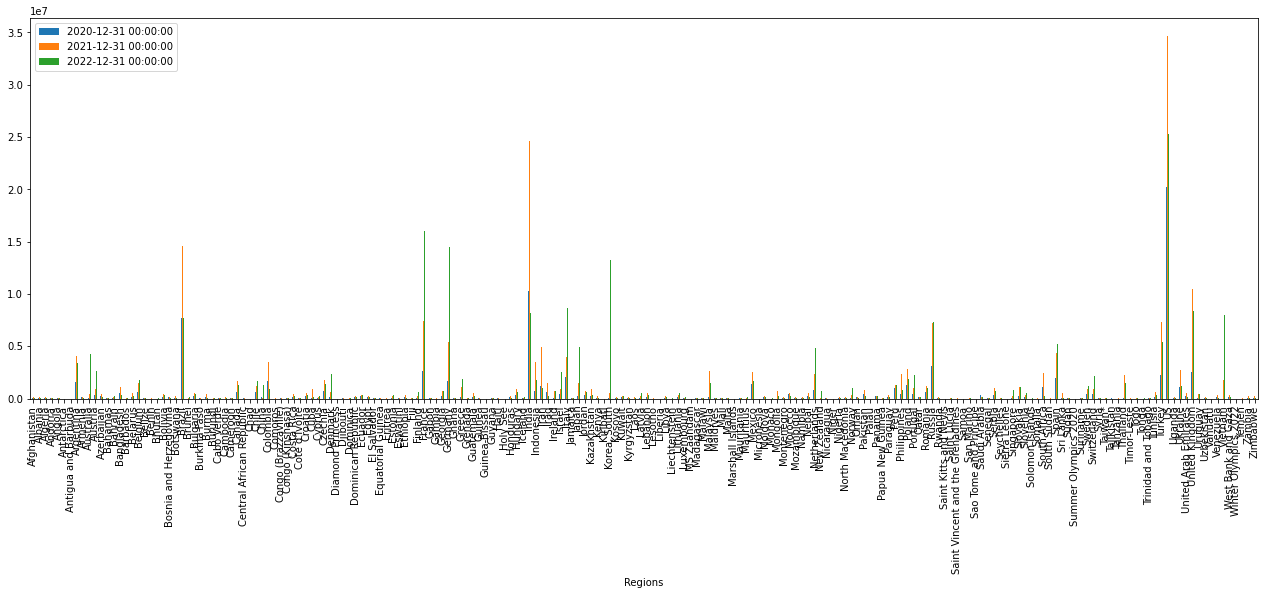

In [29]:
yearly_global = daily_global.resample('Y').sum()

yearly_global.T.plot(kind = 'bar', figsize = (22,7)); 

### Analyzing Global Deaths

In [30]:
daily_deaths_global = deaths_global.diff()
daily_deaths_global.head()

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
monthly_deaths_global = daily_deaths_global.resample('M').sum()

In [32]:
yearly_deaths_global = daily_deaths_global.resample('Y').sum()


In [33]:
totals_global = pd.concat([yearly_global, yearly_deaths_global], axis =0)
totals_global

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2020-12-31,52330.0,58316.0,99610.0,8049.0,17553.0,0.0,159.0,1625514.0,159409.0,28425.0,...,19119.0,77060.0,1.0,113558.0,1465.0,138004.0,0.0,2099.0,20725.0,13867.0
2021-12-31,105754.0,151908.0,118822.0,15691.0,64040.0,11.0,4124.0,4028894.0,185521.0,397071.0,...,394264.0,121843.0,6.0,331077.0,1729792.0,331744.0,0.0,8027.0,233549.0,199391.0
2022-12-31,19719.0,63599.0,47252.0,16284.0,17601.0,0.0,3210.0,3386232.0,77633.0,4250764.0,...,475749.0,38925.0,3874.0,76073.0,7985025.0,186002.0,535.0,1680.0,62757.0,33223.0
2020-12-31,2189.0,1181.0,2756.0,84.0,405.0,0.0,5.0,43245.0,2823.0,909.0,...,181.0,614.0,0.0,1028.0,35.0,1400.0,0.0,610.0,388.0,363.0
2021-12-31,5167.0,2036.0,3520.0,56.0,1365.0,0.0,114.0,73924.0,5149.0,1344.0,...,5989.0,871.0,1.0,4300.0,32359.0,3519.0,0.0,1374.0,3346.0,4641.0
2022-12-31,315.0,275.0,598.0,13.0,130.0,0.0,16.0,10890.0,644.0,4130.0,...,992.0,152.0,1.0,357.0,10169.0,736.0,0.0,159.0,233.0,442.0


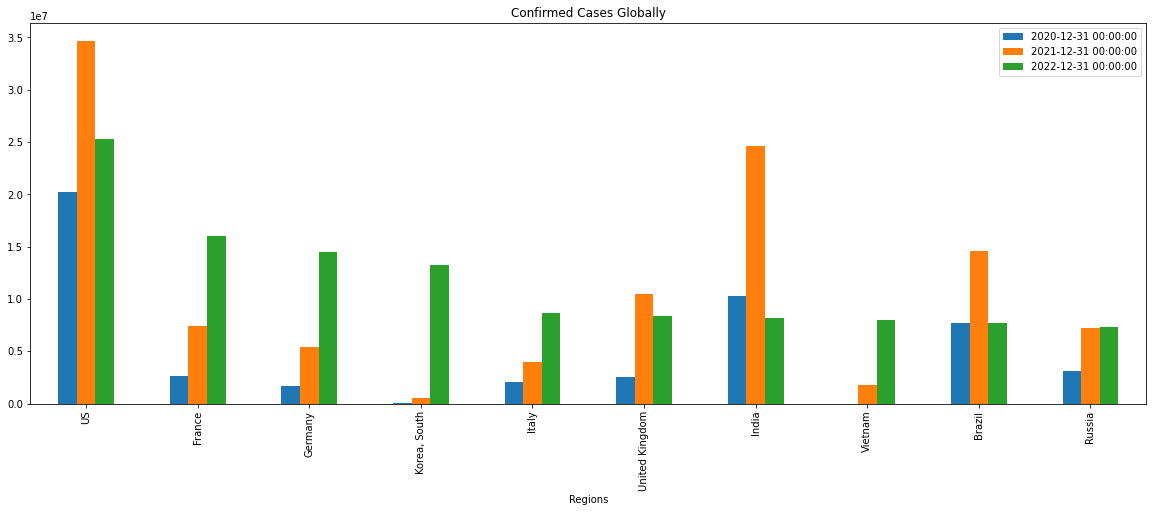

In [34]:
most_cases(yearly_global, '2022-12-31')
plt.title('Confirmed Cases Globally');

Despite India and China having higher populations than the US, US still recorded highest number of confirmed cases 


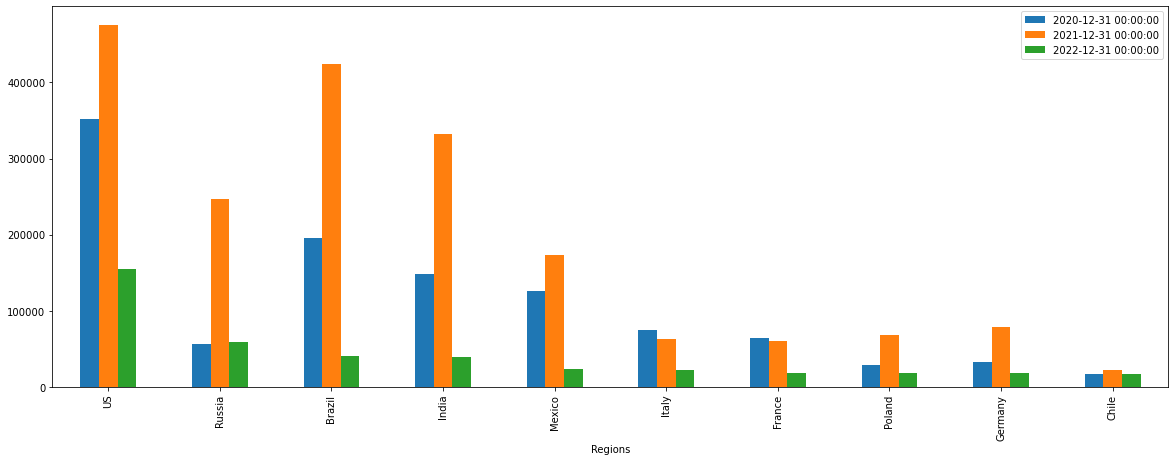

In [35]:
most_cases(yearly_deaths_global, '2022-12-31')

Looking at total deaths in 2022, US has the highest COVID related deaths. Then follows Russia, India and Brazil.

#### Comparing US Annual Death Rates to Global Annual Death Rates

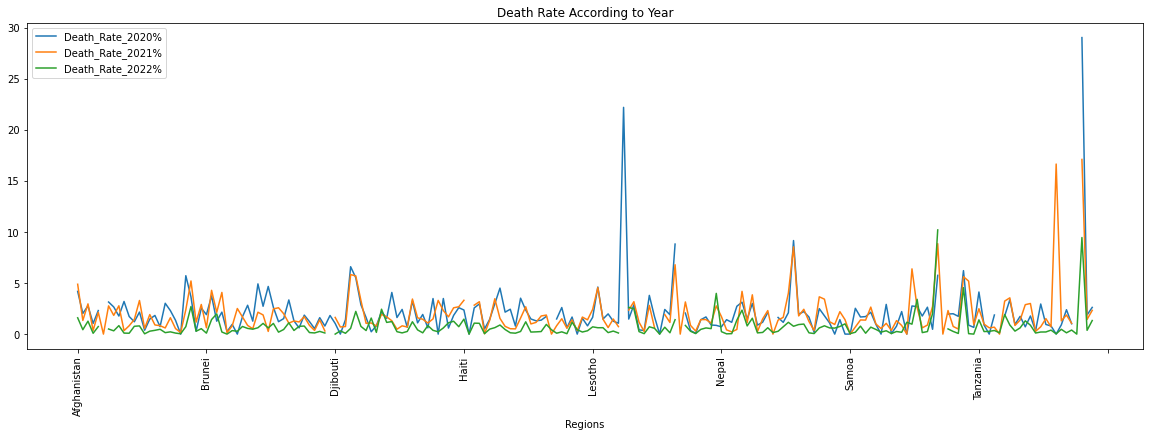

In [36]:
death_rate(totals_global)

Even though some countries may have higher death rates compared to other, looking at the graphs, it is evident that overall, the death rates across the world has been coming down since the pandemic started. 

This would be a good place to understand if having more time to learn about the virus and its spread and the protocols put in place managing the pandemic have made this impact, or its the change in variances in lower mortality rates or a combination have made this impact. Additionally, identifying the countries with lowest mortalities and finding out their management plans would be a great way to spread the knowledge on the management of the pandemic for the future. 

The US ranks 3rd place in ranking on population in the world. China and India marks 1st and 2nd place. Yet, the US has the highest recorded number of confirmed cases. Could be reflect reality, or could it be an error in reporting or lack of test kits to identify the true confirmed cases in the population?

## Data Modeling

Since this a forcasting project, following models will be considered for the project:

Arima - fitting time series data to predict future

GARTH - Fitting data of irregular patterns

Sarima - Understand sime series with seasonality

## Implementing ARIMA Model

#### Checking for Stationary and Non Stationary Data

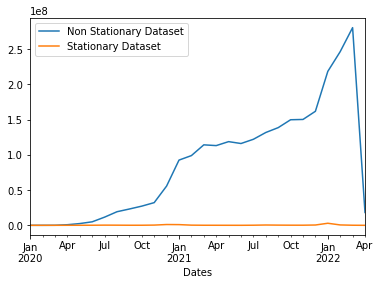

In [37]:
total_monthly_US['California'].plot() # Cases to date
monthly_US['California'].plot() # Cases on that specific date
plt.legend(['Non Stationary Dataset', 'Stationary Dataset']);

In [38]:
print(adfuller(total_monthly_US['California'].dropna())[1])

0.9476316269764533


Looking at the total cases to date, p value>0.05, which accepts null hypothesis which says the data are non-stationary. 

So, we remove the trend by getting cases per day instead of total cases till the date. 



In [39]:
print(adfuller(monthly_US['California'].dropna())[1])

0.0018794945832222587


Removing the trend and calculating cases by month generates a p value> 0.05 which signifies a stationary dataset.

### Splitting The Daily Confirmed Cases in The US¶

In [40]:
len(daily_US), len(daily_US)*.7

(802, 561.4)

In [41]:
train_dUS = daily_US[:544]
test_dUS = daily_US[544:]

### Splitting The Monthly Confirmed Cases in The US

In [42]:
len(monthly_US), len(monthly_US)*.7

(28, 19.599999999999998)

In [43]:
# Training and test tests on daily_US dataset
train_mUS = monthly_US[:19]
test_mUS = monthly_US[19:]
len(train_mUS), len(test_mUS)

(19, 9)

### Conducting ARIMA on the Stationary Dataset

#### Finding the order with the minimum error value

In [44]:
find_order(train_mUS, test_mUS, 'California', monthly_US)

(2, 2, 0) 861213.4334815984


The relevent p, q, d values are 1, 2, 0 respectively.

#### Training the Model with the Order With the Least RMSE

In [45]:
model_a = ARIMA(train_mUS['California'], order = (1,1,1)).fit()

#### Making Predictions on Existing Data

In [46]:
pred1 = model_a.predict(start = len(train_mUS), end = (len(monthly_US)+3))

#### Plotting Predictions Made on Current Data

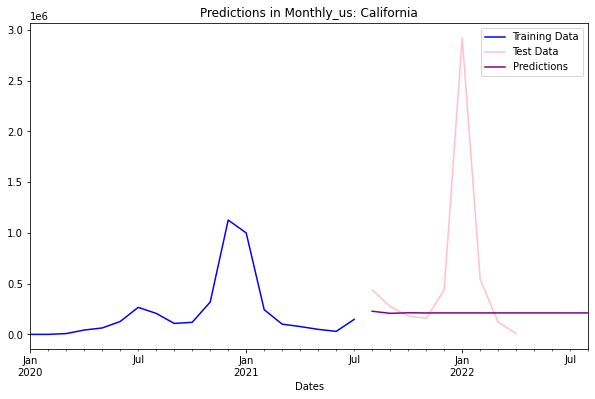

In [47]:
plot_preds(train_mUS, test_mUS, 'California', pred1, 'Monthly_US')

### Predicting Using Monthly Deaths Data in The US

In [48]:
monthly_deaths_US = daily_deaths_US.resample('M').sum()

In [49]:
len(monthly_deaths_US), len(monthly_deaths_US)*.7

(28, 19.599999999999998)

In [50]:
# Splitting data 70% trainning, 30% testing
train_mdUS = monthly_deaths_US[:19]
test_mdUS = monthly_deaths_US[19:]

#### Finding the Best Order 

In [51]:
find_order(train_mdUS, test_mdUS, 'California', monthly_deaths_US)

(0, 1, 4) 1368.7293195190255


#### Make Predictions

In [52]:
model = ARIMA(train_mdUS['California'], order = (0,0,8)).fit()
preds = model.predict(start = len(train_mdUS), end = (len(monthly_deaths_US)+3))

#### Plot Data

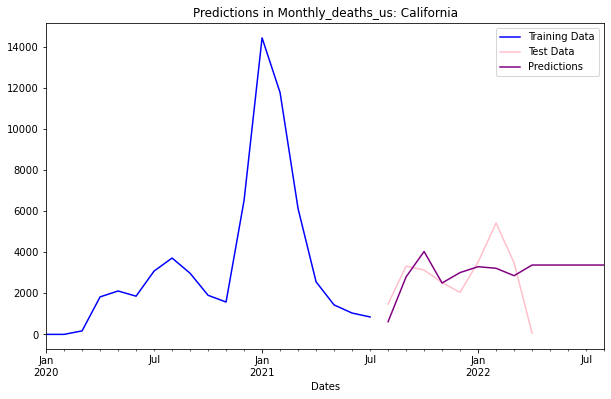

In [53]:
plot_preds(train_mdUS, test_mdUS, 'California', preds, 'Monthly_Deaths_US')

### Predict Confirmed Cases in Italy

In [54]:
len(monthly_global), len(monthly_global)*.7

(28, 19.599999999999998)

In [55]:
train_mGlobal = monthly_global[:19]
test_mGlobal = monthly_global[19:]

In [56]:
find_order(train_mGlobal, test_mGlobal, 'Italy', monthly_global)

(1, 2, 4) 1390912.486329317


In [57]:
model = ARIMA(train_mGlobal['Italy'], order = (1,1,0)).fit()
preds = model.predict(start = len(train_mGlobal), end = (len(monthly_global)+3))

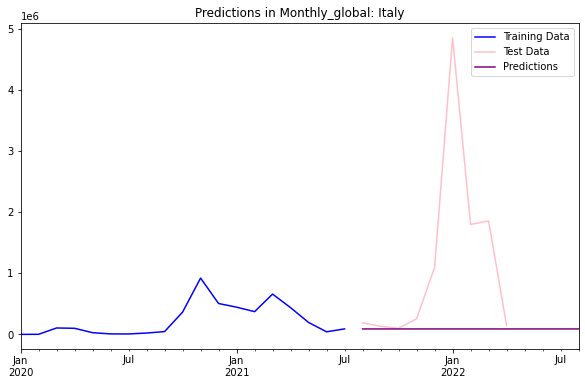

In [58]:
plot_preds(train_mGlobal, test_mGlobal, 'Italy', preds, 'monthly_global')

### Predicting Deaths in Italy

In [59]:
#Split data 
train_mdGlobal = monthly_deaths_global[:19]
test_mdGlobal = monthly_deaths_global[19:]

In [60]:
# Find the best order
find_order(train_mdGlobal, test_mdGlobal, 'Italy', monthly_deaths_global)

(5, 2, 1) 2954.008546064117


8,0,7

In [61]:
# Make predictions using the best order p, d, q
model = ARIMA(train_mdGlobal['Italy'], order = (3,1,7)).fit()
preds = model.predict(start =  len(train_mdGlobal), end = (len(monthly_deaths_global)+3))

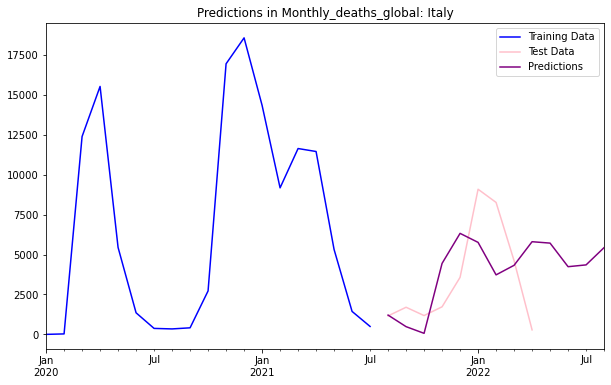

In [62]:
# Plot the predictions
plot_preds(train_mdGlobal, test_mdGlobal, 'Italy', preds, 'monthly_deaths_global')

## Implementing SARIMA Model - Seasonal ARIMA

### US Data

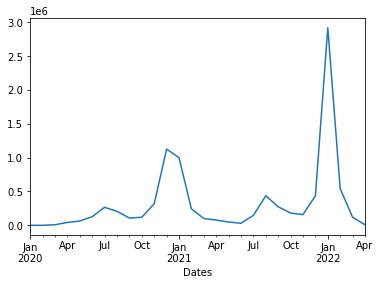

In [63]:
monthly_US['California'].plot();

the monthly data are non stationary. January of the last 2 years seem to have a spike in cases. Therefore, let's try the SARIMA model.

In [64]:
import statsmodels.api as sm

Check the original total_monthly_US dataset which shows the totals cases upto the month and detect trends with seasonal_decompose

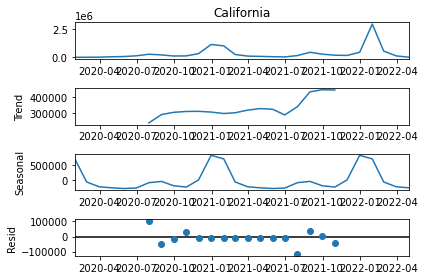

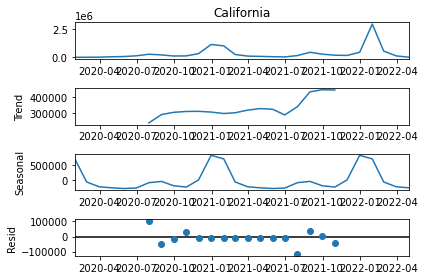

In [65]:
decomposition = sm.tsa.seasonal_decompose(monthly_US['California'], model = 'additive')
decomposition.plot()

As we can see, there is a trend and seasonal changes of cases. 

Let's confirm stationary of data with Dicky-Fuller test

In [66]:
print(adfuller(total_monthly_US['California'].dropna())[1])

0.9476316269764533


The p-value > 0.05, accepts the null hypothesis which means it has has unit roots and infer that the data are nonstationary and there are time dependant factors. 

In [67]:
adfuller(monthly_US['California'])[1]

0.0018794945832222587

Total_monthly_US which shows the total cases upto that month is non-stationary. However, the monthly_US dataset which shows only the cases in that specific month is stationary. 

Let's view this stationary and non stationary data.

#### Stationary and Non Stationary Data

#### ACF and PACF

"ACF measures and plots the average correlation between data points in a time series and previous values of the series measured for different lag lengths. A PACF is similar to an ACF except that each partial correlation controls for any correlation between observations of a shorter lag length."

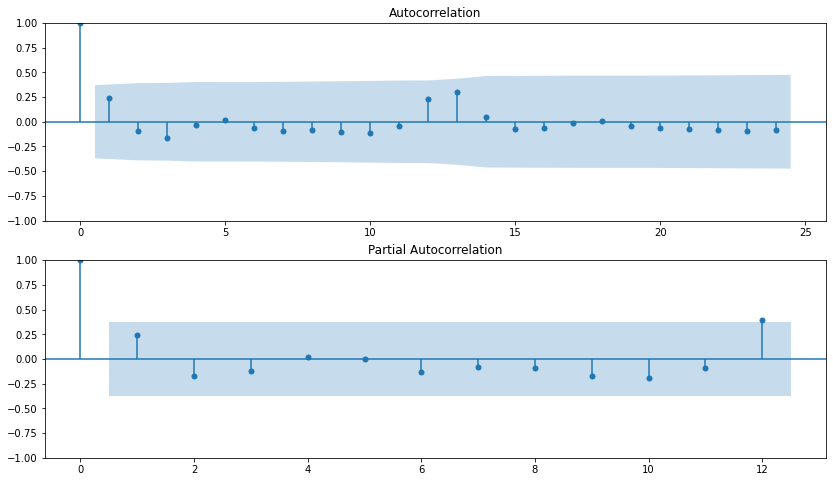

In [68]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize= (14,8))

ax1 = plot_acf(monthly_US['California'],ax= ax1, lags = 24)
ax2 = plot_pacf(monthly_US['California'], ax = ax2, lags = 12)



1st time there's a spike in autocorrolation is at 12 months. 

### Plotting Predictions Obtained from the ACF and PACF data

In [69]:
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)
model_x = SARIMAX(train_mUS['California'], order = my_order, seasonal_order = my_seasonal_order ).fit(dis = -1)

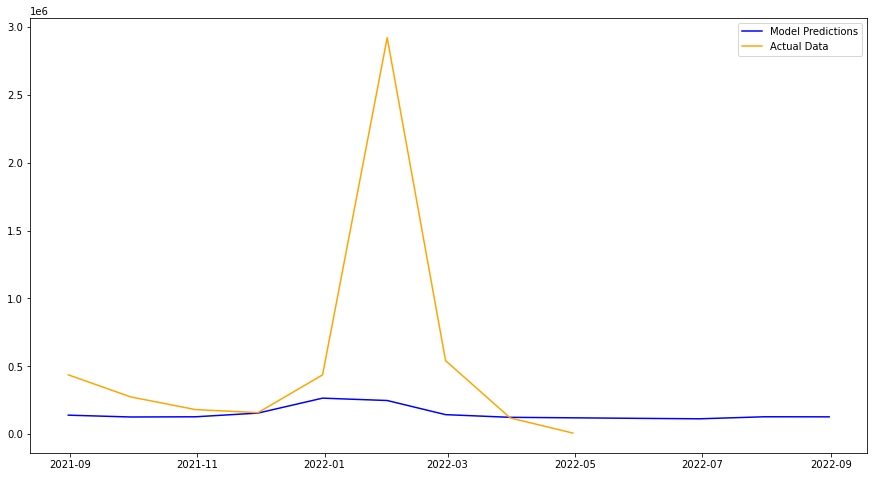

In [70]:
plot_sarimax_preds(train_mUS, 'California', test_mUS, (0,1,0), (1,0,1,12), monthly_US)

### Finding Best Orders and Seasonal Orders

In [71]:
# set parameter range
p,d,q = range(0,4),[1],range(0,4)
P,D,Q,s = range(0,4),[1],range(0,4),[12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

#### Testing Monthly_US Dataset

In [72]:
# Finding the best order and seasonal order
sarimax(monthly_US['California'][:19], all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:177.16
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:173.1
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:175.02
Tried out SARIMAX(0, 1, 0)x(0, 1, 3, 12) - AIC:177.02
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:173.59
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:175.03
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:177.02
Tried out SARIMAX(0, 1, 0)x(1, 1, 3, 12) - AIC:179.02
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:175.02
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:177.02
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:179.02
Tried out SARIMAX(0, 1, 0)x(2, 1, 3, 12) - AIC:181.02
Tried out SARIMAX(0, 1, 0)x(3, 1, 0, 12) - AIC:8.0
Tried out SARIMAX(0, 1, 0)x(3, 1, 1, 12) - AIC:179.02
Tried out SARIMAX(0, 1, 0)x(3, 1, 2, 12) - AIC:181.02
Tried out SARIMAX(0, 1, 0)x(3, 1, 3, 12) - AIC:183.02
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:152.3
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:153.66
Tried out SARIMAX(0, 1, 1)x(0, 1,

Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:3.609186904889996e+16
Tried out SARIMAX(2, 1, 1)x(2, 1, 3, 12) - AIC:3.609186904889978e+16
Tried out SARIMAX(2, 1, 1)x(3, 1, 0, 12) - AIC:3.609186904889945e+16
Tried out SARIMAX(2, 1, 1)x(3, 1, 1, 12) - AIC:3.609186904889978e+16
Tried out SARIMAX(2, 1, 1)x(3, 1, 2, 12) - AIC:3.6091869048899944e+16
Tried out SARIMAX(2, 1, 1)x(3, 1, 3, 12) - AIC:3.609186904889947e+16
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:169.05
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:170.96
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:172.93
Tried out SARIMAX(2, 1, 2)x(0, 1, 3, 12) - AIC:174.92
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:170.91
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:172.91
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:174.91
Tried out SARIMAX(2, 1, 2)x(1, 1, 3, 12) - AIC:176.91
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:172.91
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:174.91
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AI

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d018e28940>,
  8.0,
  ((0, 1, 0), (3, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d01e7733d0>,
  10.0,
  ((1, 1, 0), (3, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d018f70280>,
  12.0,
  ((1, 1, 1), (3, 1, 0, 12)))]

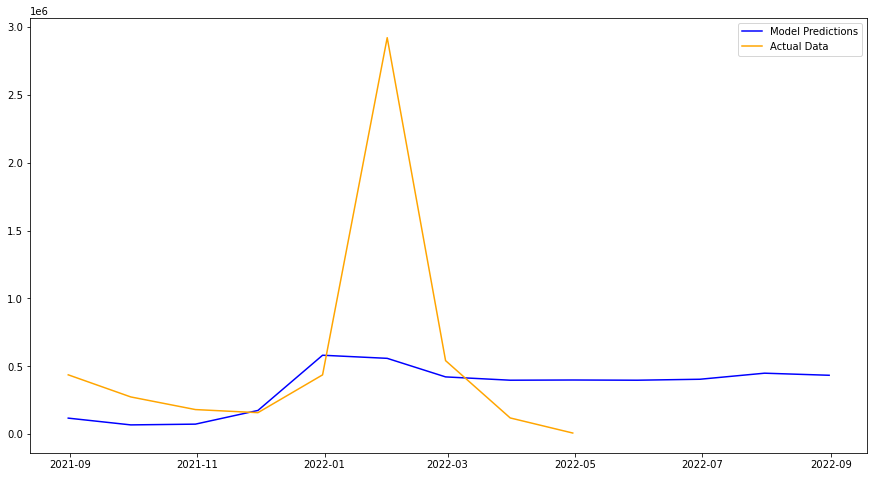

In [73]:
plot_sarimax_preds(train_mUS, 'California', test_mUS, (0,1,0), (3,1,2,12), monthly_US)

The model is trained to predict the data in a specific value range, and the spike of cases in the first quarter of 2022 is out of the value range the model is trained on. Therefore, due to extrapolation, the model did not perform well in predicting the event.

#### Experimenting with Monthly_global Dataset

In [74]:
# Finding the best order and seasonal order
sarimax(monthly_global['Italy'][:19], all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:168.16
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:162.61
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:164.03
Tried out SARIMAX(0, 1, 0)x(0, 1, 3, 12) - AIC:165.71
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:161.35
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:163.14
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:165.06
Tried out SARIMAX(0, 1, 0)x(1, 1, 3, 12) - AIC:167.06
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:163.35
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:165.14
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:167.06
Tried out SARIMAX(0, 1, 0)x(2, 1, 3, 12) - AIC:169.06
Tried out SARIMAX(0, 1, 0)x(3, 1, 0, 12) - AIC:165.35
Tried out SARIMAX(0, 1, 0)x(3, 1, 1, 12) - AIC:167.14
Tried out SARIMAX(0, 1, 0)x(3, 1, 2, 12) - AIC:12.0
Tried out SARIMAX(0, 1, 0)x(3, 1, 3, 12) - AIC:171.06
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 12) - AIC:170.0
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:165.32
Tried out SARIMAX(0, 1, 1)x(0, 

Tried out SARIMAX(2, 1, 1)x(3, 1, 1, 12) - AIC:898093116034365.8
Tried out SARIMAX(2, 1, 1)x(3, 1, 2, 12) - AIC:898093116034367.6
Tried out SARIMAX(2, 1, 1)x(3, 1, 3, 12) - AIC:898093116034366.1
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:166.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:168.57
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:170.12
Tried out SARIMAX(2, 1, 2)x(0, 1, 3, 12) - AIC:171.94
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:167.76
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:169.76
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:171.76
Tried out SARIMAX(2, 1, 2)x(1, 1, 3, 12) - AIC:173.76
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:169.76
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:171.76
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:173.76
Tried out SARIMAX(2, 1, 2)x(2, 1, 3, 12) - AIC:175.76
Tried out SARIMAX(2, 1, 2)x(3, 1, 0, 12) - AIC:171.76
Tried out SARIMAX(2, 1, 2)x(3, 1, 1, 12) - AIC:173.76
Tried out SARIMAX(2, 1, 2)x(3, 1, 2, 12) - AIC:17

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d05a881cd0>,
  12.0,
  ((0, 1, 0), (3, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d0507529d0>,
  12.0,
  ((2, 1, 0), (2, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2d0639e16d0>,
  14.0,
  ((2, 1, 0), (3, 1, 1, 12)))]

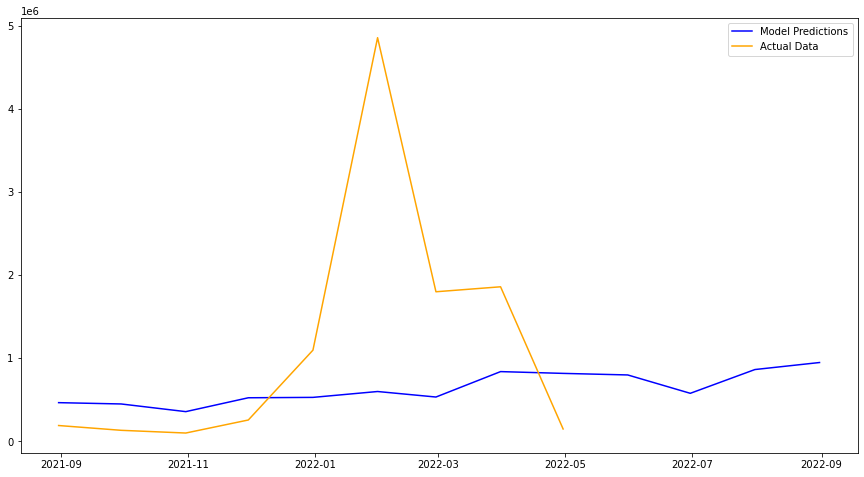

In [75]:
plot_sarimax_preds(train_mGlobal, 'Italy', test_mGlobal, (2,1,0), (2,1,1,12), monthly_global)

Except for the large spike that took place in the first quarter of 2022, the model stays close to the actual data.

Certainly, further experiments tuning the parameters can be done to make this a better model.

In [182]:
yearly_global

Regions,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2020-12-31,52330.0,58316.0,99610.0,8049.0,17553.0,0.0,159.0,1625514.0,159409.0,28425.0,...,19119.0,77060.0,1.0,113558.0,1465.0,138004.0,0.0,2099.0,20725.0,13867.0
2021-12-31,105754.0,151908.0,118822.0,15691.0,64040.0,11.0,4124.0,4028894.0,185521.0,397071.0,...,394264.0,121843.0,6.0,331077.0,1729792.0,331744.0,0.0,8027.0,233549.0,199391.0
2022-12-31,19719.0,63599.0,47252.0,16284.0,17601.0,0.0,3210.0,3386232.0,77633.0,4250764.0,...,475749.0,38925.0,3874.0,76073.0,7985025.0,186002.0,535.0,1680.0,62757.0,33223.0


In [222]:
prevalence_map(yearly_global, '2022-12-31')

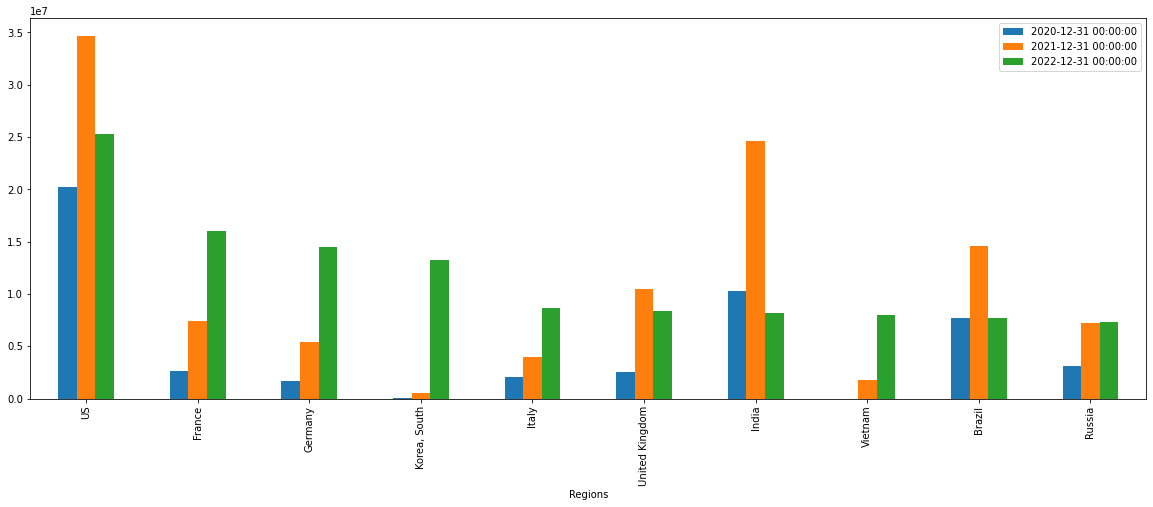

In [197]:
most_cases(yearly_global, '2022-12-31')

In [221]:
prevalence_map(deaths_global, '2022-03-31')

In [447]:
# def prevalence_mapsss (dataset, time):
#      '''
#     Visualize the prevelance of cases in a specific time frame.
#     dataset = dataset interested
#     'time' = time frame in question, by date, month, or year as a string
#     '''
#     if 'g' in str(dataset):
#         data = dict(
#             type = 'choropleth',
#             colorscale = 'jet',
#             locations =dataset.columns,
#             locationmode = "country names",
#             z = dataset.T[time],
#             text = dataset.columns,
#             colorbar = {'title' : 'Number of Cases'})

#         layout = dict(
#             title = 'Cases Related to COVID-19 in The World' ,
#             geo = dict(
#                 projection = {'type':'mercator'}))

#         choromap = go.Figure(data = [data],layout = layout)
#         iplot(choromap, validate=False)   
        
#     else:
#         data = dict(
#             type = 'choropleth',
#             colorscale = 'jet',
#             locations =dataset.columns,
#             locationmode = "USA-states",
#             z = dataset.T[time],
#             text = dataset.columns,
#             colorbar = {'title' : 'Number of Cases'})

#             # Creating a side bar
#         layout = dict(
#             title = 'Cases Related to COVID-19',
#             geo = dict(
#                 scope = 'usa', 
#                 projection = {'type' :'albers usa' } ))
# #                 projection = dict( type='albers usa' ) ))
        
#         choromap = go.Figure(data = [data],layout = layout)
#         iplot(choromap, validate=False)
    
    

In [448]:
prevalence_mapsss(monthly_deaths_US,'2021-12-31')